# App de Reconhecimento Facial
Programa de Pós-Graduação em Ciência da Computação da Universidade Federal de Campina Grande

Disciplina: Aprendizado de Máquina

Professor: Leandro Balbi

Aluno: Felipe Torres Leite

Projeto final para construir um app de reconhecimento facial, a partir do tutorial: https://www.youtube.com/watch?v=LKispFFQ5GU

Tarefa: https://canvas.instructure.com/courses/5142637/assignments/33684829

# 1. Setup

## 1.1 Install Dependencies

In [ ]:
#!pip install tensorflow==2.5.0 tensorflow-gpu==2.5.0 --user opencv-python matplotlib

Instalando o TensorFlow, biblioteca de código aberto de aprendizado de máquina usada para reconhecimento de padrões em redes neurais. Para melhorar o desempenho, também está sendo usada a tensorflow-gpu, criando um processador dedicado para processar as informações gráficas que serão usadas.

Opencv é uma biblioteca bastante utilizada na computação gráfica e será utilizada no momento de execução da aplicação. Matplotlib é uma biblioteca de software para criação de gráficos e visualizações de dados em geral que irá ajudar também na execução deste app.

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

Importando as dependências para utilizar no Deep Learning que será aplicado aqui no app. O Keras é outra biblioteca, que roda em cima do TensorFlow, para redes neurais com deep learning.

Aqui são importas as dependências para a construção do app, em como vai lidar com as imagens que serão utilizadas para treinamento, reconhecimento e mostrá-las em um gráfico 2D durante a execução.

## 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Esta seção de código só existe porque será usado o GPU na execução e serve para evitar erros de falta de memória.

In [5]:
len(gpus)

0

Quantidade de GPUs utilizadas.

## 1.4 Create Folder Structures

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: 'data\\positive'

É criada uma estrutura de pastas/diretórios 'anchor', 'negative' e 'positive' para serem passados os dados (imagens).

**Imagem Âncora**: Imagem passada como entrada que é a imagem correta que é passada. Corresponde à imagem capturada da câmera durante a execução do app.

As outras duas estruturas correspondem à imagem que será comparada com a Imagem Âncora.

**Imagem Negativa**: Quando a imagem NÃO corresponder à imagem âncora (RESULTADO NEGATIVO/FALSO).

**Imagem Positiva**: Quando a imagem corresponder à imagem âncora (RESULTADO POSITIVO/VERDADEIRO).

Assim, a rede neural poderá reconhecer se a imagem a ser comparada com a imagem âncora é SEMELHANTE (Positiva) ou é DIFERENTE (Negativa).


# 2. Collect Positives and Anchors

Será utilizado um repositório de imagens rotuladas disponíveis na internet.

As imagens rotuladas serão utilizadas como Imagens Negativas para o treinamento da rede.

As imagens Âncora e Positivas serão imagens de entrada, capturadas pela câmera durante a execução do app. Serão imagens capturadas em momentos distintos mas naturalmente serão semelhantes (positivas). As imagens positivas serão utilizadas para treinar a rede neural para detectar a semelhança quando a imagem âncora for passada como parâmetro de entrada.

As imagens âncora serão utilizadas em tempo de execução como parâmetro para serem avaliadas pela rede neural. O modelo, já treinado com as imagens positivas e negativas, irá apresentar o resultado final comparando a imagem passada em tempo real com o que ela já aprendeu, a partir de seu treinamento. 

Assim, resultada em verdadeiro quando a imagem âncora for SEMELHANTE à POSITIVA ou falso quando NÃO FOR SEMELHANTE à POSITIVA.

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

Repositório de imagens rotuladas para serem usadas como imagens negativas.

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz

Baixando as imagens rotuladas para serem utilizadas no treinamento da rede neural, descompactando e adicionando uma nova pasta (lfw) onde estão as imagens baixadas ao repositório do app. O rótulo mencionado significa que as imagens estão organizadas em subpastas nomeadas com o nome da pessoa que corresponde à(s) imagem(ns) na respectiva subpasta.

Inicialmente, todas estas imagens estão na pasta/diretório 'lfw'.

In [6]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Movendo os arquivos (imagens) de 'lfw' para o nosso diretório de imagens negativas 'data/negative'.

## 2.2 Collect Positive and Anchor Classes

Esta seção faz a conexão com a webcam para capturar as imagens âncora e positivas, configurando-as para o mesmo formato (250x250 px) correspondente ao formato das imagens rotuladas que já foram adicionadas na pasta 'negative'.

In [7]:
# Import uuid library to generate unique image names
import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\60d898f1-725b-11ed-8dcd-082e5f739565.jpg'

In [13]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

Após estabelecer uma conexão com a webcam para captura de imagens em tempo de execução, um loopp é iniciado para adicionar imagens reais capturadas para serem utilizadas no treinamento da rede siamesa. As imagens capturadas devem ser adicionadas nas pastas ANCHOR e POSITIVE conforme execução dos comandos 'a' e 'p', respectivamente. A quantidade de imagens capturadas e adicionadas em ambas as pastas impactará na eficácia do treinamento do modelo para reconhecimento de imagens, posteriormente. Portanto, deve-se haver uma quantidade considerável de arquivos de imagens. Para encerrar o loop da execução da webcam, o comando 'q' deve ser acionado.

*Optei adicionar pelo menos uma quantidade superior a 100 imagens para ambas as pastas.*


A imagem é tratada para ser capturada na proporção de 250:250px para corresponder à mesma proporção das imagens rotuladas que estão na pasta NEGATIVE, para padronizar os arquivos para o treinamento da rede.

In [14]:
frame.shape

(250, 250, 3)

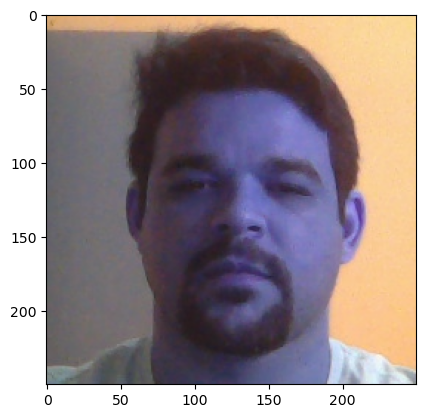

In [15]:
plt.imshow(frame)

# 2.x NEW - Data Augmentation

In [16]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [17]:
import os
import uuid

In [18]:
img_path = os.path.join(ANC_PATH, 'a11cd416-71f8-11ed-885c-082e5f739565.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [19]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

KeyboardInterrupt: 

# 3. Load and Preprocess Images

Agora, vai iniciar o pré-processamento das imagens carregadas no diretório de dados.

## 3.1 Get Image Directories

In [20]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [21]:
dir_test = anchor.as_numpy_iterator()

In [22]:
print(dir_test.next())

b'data\\anchor\\1df6a83c-7235-11ed-a981-082e5f739565.jpg'


Nesta seção, as pastas ANCHOR, POSITIVE e NEGATIVE são usadas para ancorar imagens verdadeiras (positivas) e falsas (negativas), criando um pipeline de todos os arquivos diferentes dos diretórios. Desta forma, durante o treinamento, cada arquivo poderá ser usado individualmente para que sejam feitas as respectivas análises da rede.

## 3.2 Preprocessing - Scale and Resize

In [23]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [24]:
img = preprocess('data\\anchor\\a11cd416-71f8-11ed-885c-082e5f739565.jpg')

In [25]:
img.numpy().max() 

1.0

In [ ]:
#dataset.map(preprocess)

Neste pré-processamento, a imagem é redimensionada para 100x100 (em 3 canais - RGB) e escalonada para ser uma variação de 0's e 1's, ao invés de 0 a 255 do RGB, para facilitar o reconhecimento de imagens pela rede. 

*O redimensionamento acontece para seguir o artigo utilizado como base.*

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [26]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [27]:
samples = data.as_numpy_iterator()

In [28]:
exampple = samples.next()

In [29]:
exampple

(b'data\\anchor\\371c791c-7235-11ed-92af-082e5f739565.jpg',
 b'data\\positive\\b1db3e56-725b-11ed-be54-082e5f739565.jpg',
 1.0)

Criando o conjunto de dados (matrizes) rotulados como sendo positivos (1) ou negativos (0).

## 3.4 Build Train and Test Partition

In [30]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label) #retornando a imagem processada

In [31]:
res = preprocess_twin(*exampple)

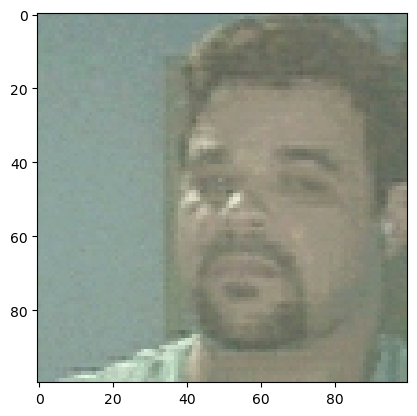

In [34]:
plt.imshow(res[1])

Pré-processamento das imagens e confirmando uma imagem rotulada em tamanho 100x100.

In [35]:
res[2]

1.0

Rótulo como sendo 1 para a imagem exibida, que é verdadeira e portanto está correta a rotulação.

In [36]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000) #embaralha as imagens para evitar criar viés

In [37]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [38]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Construindo o pipeline das imagens para o treinamento. Pega as imagens validadas, positivas e negativas, embaralha para realizar o treinamento e depois o teste.

One-shot: Será passada uma imagem âncora ou positiva e, em seguida, pode ser passada uma imagem separada para ser avaliada/reconhecida e o resultado é 0 ou 1 (se é a mesma pessoa ou não)

# 4. Model Engineering

Construindo o modelo de rede neural siamesa para reconhecimento de imagens one shot.

## 4.1 Build Embedding Layer

Construindo as camadas da rede.

In [39]:
inp = Input(shape=(100,100,3), name='input_image')

In [40]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [41]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [42]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [43]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [44]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [45]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [46]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [47]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [48]:
embedding = make_embedding()

In [49]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [50]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [51]:
l1 = L1Dist()

In [ ]:
#l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [52]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [53]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [54]:
siamese_layer = L1Dist()

In [55]:
distances = siamese_layer(inp_embedding, val_embedding)

In [56]:
classifier = Dense(1, activation='sigmoid')(distances)

In [57]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [58]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [59]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [61]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [62]:
siamese_model = make_siamese_model()

In [63]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

Agora iniciará o treinamento da rede para reconhecer imagens de entrada da webcam, em tempo real, para comparar com o modelo treinado da rede siamesa e identificar se a imagem de entrada corresponde à pessoa, a qual foi treinada para reconhecer, ou não.

## 5.1 Setup Loss and Optimizer

In [56]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [57]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [58]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [59]:
test_batch = train_data.as_numpy_iterator()

In [60]:
batch_1 = test_batch.next()

In [61]:
X = batch_1[:2]

In [62]:
y = batch_1[2]

In [63]:
y

array([1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

In [64]:
tf.losses.BinaryCrossentropy??

In [65]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [66]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [68]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


 Epoch 1/50
10/10 [==============================] - 260s 26s/step
0.03713088 1.0 1.0

 Epoch 2/50
10/10 [==============================] - 254s 25s/step
0.01877898 1.0 1.0

 Epoch 3/50
10/10 [==============================] - 258s 26s/step
0.0062145535 1.0 1.0

 Epoch 4/50
10/10 [==============================] - 258s 26s/step
0.031566422 1.0 1.0

 Epoch 5/50
10/10 [==============================] - 247s 25s/step
0.05424415 1.0 1.0

 Epoch 6/50
10/10 [==============================] - 248s 25s/step
0.11452762 1.0 1.0

 Epoch 7/50
10/10 [==============================] - 261s 26s/step
0.0017099433 1.0 1.0

 Epoch 8/50
10/10 [==============================] - 249s 25s/step
0.03938085 1.0 1.0

 Epoch 9/50
10/10 [==============================] - 259s 26s/step
0.004094234 1.0 1.0

 Epoch 10/50
10/10 [==============================] - 257s 26s/step
0.036431696 1.0 1.0

 Epoch 11/50
10/10 [==============================] - 277s 28s/step
0.0035346209 1.0 1.0

 Epoch 12/50
10/10 [===========

Foi utilizado o treinamento em 50 EPOCHS, o qual foi realizado em cerca de 3h em uma máquina do tipo notebook, marca HP, processaor intel i7. Ao final do treinamento, o modelo será salvo em um arquivo para que o app utilize-o como base para fazer o reconhecimento. 

# 6. Evaluate Model

Iniciando a avaliação do modelo, aplicando métricas de desempenho para coletar informações sobre a sua eficácia.

## 6.1 Import Metrics

In [64]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

Métricas *Precision* e *Recall* que serão calculadas para avaliar o modelo.

## 6.2 Make Predictions

In [65]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [66]:
y_hat = siamese_model.predict([test_input, test_val])

In [67]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [68]:
y_true

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [69]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [70]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [71]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.11111111 0.8


## 6.4 Viz Results

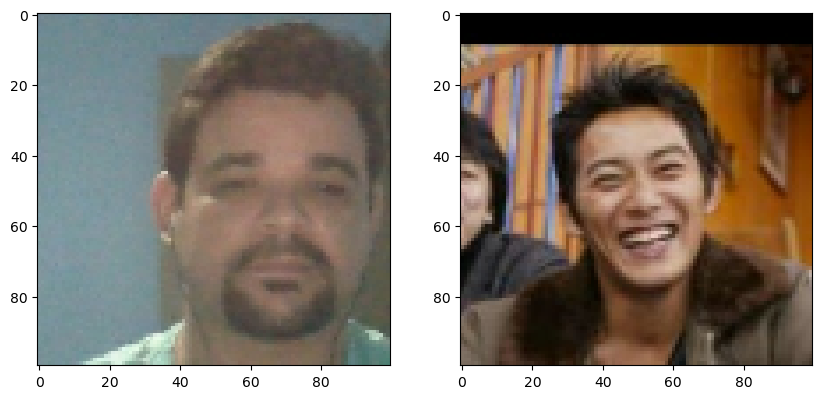

In [72]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

Sallvando o modelo em um arquivo chamado 'siamesemodelv2.h5' para ser usado como base para fazer o reconhecimento facial do app.

In [83]:
# Save weights
siamese_model.save('siamesemodelv2.h5') #modelo treinado

In [73]:
L1Dist

__main__.L1Dist

In [74]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [75]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[1.7881155e-06],
       [6.8588690e-08],
       [1.6981103e-08],
       [1.0000000e+00],
       [9.4876122e-01],
       [2.5126820e-07],
       [1.2818559e-06]], dtype=float32)

In [76]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

Será realizado o teste de reconhecimento facial do app, a partir do modelo treinado, de uma imagem de entrada da webcam, produzindo como saída: (i) TRUE, para resultado positivo/verdadeiro sobre o reconhecimento (significa que a imagem capturada em tempo real corresponde à imagem que foi usada para o treino, ou seja, a rede reconheceu a pessoa que capturou sua imagem na webcam como sendo a mesma pessoa que a rede aprendeu); ou FALSE, para resultado negativo/falso sobre o reconhecimento (significa que a imagem capturada em tempo real NÃO corresponde à imagem que foi usada para o treino, ou seja, a rede reconheceu a pessoa que capturou sua imagem na webcam como sendo OUTRA pessoa DIFERENTE do que a rede aprendeu).

## 8.1 Verification Function

In [88]:
#application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [77]:
os.listdir(os.path.join('application_data', 'verification_images'))

['1825fc0d-7235-11ed-b725-082e5f739565.jpg',
 '1969ca5a-7235-11ed-bd5b-082e5f739565.jpg',
 '20a61a77-7235-11ed-a3e8-082e5f739565.jpg',
 '26e51cc2-7235-11ed-a1e7-082e5f739565.jpg',
 '28ce7e35-7235-11ed-99cf-082e5f739565.jpg',
 '29174f6a-7235-11ed-aeeb-082e5f739565.jpg',
 '295d5c20-7235-11ed-8b66-082e5f739565.jpg',
 '29e7ce2c-7235-11ed-b01e-082e5f739565.jpg',
 '30d42eec-7235-11ed-9b15-082e5f739565.jpg',
 '315d66c0-7235-11ed-a42c-082e5f739565.jpg',
 '3379a1ec-7235-11ed-8e9e-082e5f739565.jpg',
 '33d5c745-7235-11ed-a2e7-082e5f739565.jpg',
 '36e282aa-7235-11ed-8b12-082e5f739565.jpg',
 '371c791c-7235-11ed-92af-082e5f739565.jpg',
 '379ed95f-7235-11ed-9a03-082e5f739565.jpg',
 '37dfccb2-7235-11ed-aa84-082e5f739565.jpg',
 '39bd042e-7235-11ed-b25d-082e5f739565.jpg',
 '39f4aa64-7235-11ed-b8b0-082e5f739565.jpg',
 '3ca1a7d4-7235-11ed-a077-082e5f739565.jpg',
 '3d3fc727-7235-11ed-9df0-082e5f739565.jpg',
 '3db147a7-7235-11ed-acd4-082e5f739565.jpg',
 '3dd521a2-7235-11ed-9644-082e5f739565.jpg',
 '3e095ff3

In [78]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [79]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\1825fc0d-7235-11ed-b725-082e5f739565.jpg
application_data\verification_images\1969ca5a-7235-11ed-bd5b-082e5f739565.jpg
application_data\verification_images\20a61a77-7235-11ed-a3e8-082e5f739565.jpg
application_data\verification_images\26e51cc2-7235-11ed-a1e7-082e5f739565.jpg
application_data\verification_images\28ce7e35-7235-11ed-99cf-082e5f739565.jpg
application_data\verification_images\29174f6a-7235-11ed-aeeb-082e5f739565.jpg
application_data\verification_images\295d5c20-7235-11ed-8b66-082e5f739565.jpg
application_data\verification_images\29e7ce2c-7235-11ed-b01e-082e5f739565.jpg
application_data\verification_images\30d42eec-7235-11ed-9b15-082e5f739565.jpg
application_data\verification_images\315d66c0-7235-11ed-a42c-082e5f739565.jpg
application_data\verification_images\3379a1ec-7235-11ed-8e9e-082e5f739565.jpg
application_data\verification_images\33d5c745-7235-11ed-a2e7-082e5f739565.jpg
application_data\verification_images\36e282aa-7235-11ed-8b12-082

In [80]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

Executando o app, abrindo a webcam, permitindo a captura da imagem para ser comparada no modelo.

In [81]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
True
False
True
False
True
True
False
True
True
False


Resultados de cada teste feito com a rede neural em tempo real.

TRUE: Pessoa reconhecida.

FALSE: Pessoa NÃO reconhecida.

In [1]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'np' is not defined

In [83]:
results

[array([[4.1648207e-05]], dtype=float32),
 array([[7.211093e-05]], dtype=float32),
 array([[0.00011932]], dtype=float32),
 array([[3.923508e-06]], dtype=float32),
 array([[1.0145925e-06]], dtype=float32),
 array([[3.2003336e-05]], dtype=float32),
 array([[1.3745089e-05]], dtype=float32),
 array([[2.4269495e-05]], dtype=float32),
 array([[9.2645087e-07]], dtype=float32),
 array([[7.087234e-07]], dtype=float32),
 array([[4.502708e-05]], dtype=float32),
 array([[7.107927e-05]], dtype=float32),
 array([[0.00014433]], dtype=float32),
 array([[6.4912376e-05]], dtype=float32),
 array([[1.4065248e-05]], dtype=float32),
 array([[2.1747588e-05]], dtype=float32),
 array([[3.1421334e-06]], dtype=float32),
 array([[4.621514e-06]], dtype=float32),
 array([[1.5181279e-05]], dtype=float32),
 array([[8.9212945e-06]], dtype=float32),
 array([[2.7141976e-05]], dtype=float32),
 array([[5.150932e-05]], dtype=float32),
 array([[1.0338825e-06]], dtype=float32),
 array([[3.1048098e-06]], dtype=float32),
 arra

# Considerações Finais

Este código foi reproduzido de Nicholas Renotte, extraído do vídeo no Youtube intitulado de "Build a Python Facial Recognition App with Tensorflow and Kivy".

Foi desenvolvida uma rede neural siamesa one shot, baseada em um artigo científico de 2015, intitulado por "Siamese Neural Networks for One-shot Image Recognition" dos autores Gregory Koch, Richard Zemel e Ruslan Salakhutdinov, da Universidade de Toronto. Portanto, o objetivo deste código é implementar esta rede em python para a realização de reconhecimento facial, a partir de uma imagem capturada em tempo real.

Após alguns ajustes para a execução em uma máquina local, o app conseguiu cumprir seu objetivo em reconhecer um indivíduo quando executado de forma eficaz, mesmo que tenha apresentado (minimamente) falso-positivo e falso-negativo em testes realizados.